In [1]:
import numpy as np
import pandas as pd

In [2]:
train = pd.read_csv("./Train.csv")
test = pd.read_csv("./test.csv")

In [3]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test],sort=True)
print(train.shape,test.shape,data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [4]:
data.apply(lambda x: sum(x.isnull()))

Item_Fat_Content                0
Item_Identifier                 0
Item_MRP                        0
Item_Outlet_Sales            5681
Item_Type                       0
Item_Visibility                 0
Item_Weight                  2439
Outlet_Establishment_Year       0
Outlet_Identifier               0
Outlet_Location_Type            0
Outlet_Size                  4016
Outlet_Type                     0
source                          0
dtype: int64

In [5]:
data.describe()

,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Establishment_Year
count,14204.000000,8523.000000,14204.000000,11765.000000,14204.000000
mean,141.004977,2181.288914,0.065953,12.792854,1997.830681
std,62.086938,1706.499616,0.051459,4.652502,8.371664
min,31.290000,33.290000,0.000000,4.555000,1985.000000
25%,94.012000,834.247400,0.027036,8.710000,1987.000000
50%,142.247000,1794.331000,0.054021,12.600000,1999.000000
75%,185.855600,3101.296400,0.094037,16.750000,2004.000000
max,266.888400,13086.964800,0.328391,21.350000,2009.000000


In [6]:
data.apply(lambda x: len(x.unique()))

Item_Fat_Content                 5
Item_Identifier               1559
Item_MRP                      8052
Item_Outlet_Sales             3494
Item_Type                       16
Item_Visibility              13006
Item_Weight                    416
Outlet_Establishment_Year        9
Outlet_Identifier               10
Outlet_Location_Type             3
Outlet_Size                      4
Outlet_Type                      4
source                           2
dtype: int64

In [7]:
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']

In [8]:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]

In [9]:
for col in categorical_columns:
    print('\nFrequency of Categories of vairable %s'%col)
    print(data[col].value_counts())


Frequency of Categories of vairable Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories of vairable Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories of vairable Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

Frequency of Categories of vairable Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

F

### Data Cleaning

#### Imputing Missing Values

In [10]:
item_avg_weight = data["Item_Weight"].mean()
print(item_avg_weight)

12.792854228644991


In [11]:
data["Item_Weight"] = data["Item_Weight"].fillna(item_avg_weight)

In [12]:
from scipy.stats import mode

outlet_size_mode = data.pivot_table(values = 'Outlet_Size',columns="Outlet_Type",aggfunc=(lambda x:mode(x).mode[0]))
print("Mode for each outlet type")
print(outlet_size_mode)

miss_bool = data['Outlet_Size'].isnull()
print("\n Original #missing: %d"% sum(miss_bool))

data.loc[miss_bool,'Outlet_Size'] = data.loc[miss_bool,'Outlet_Type'].apply(lambda x: outlet_size_mode[x])

Mode for each outlet type
Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2  \
Outlet_Size         Small             Small            Medium   

Outlet_Type Supermarket Type3  
Outlet_Size            Medium  

 Original #missing: 4016


In [13]:
print(sum(data['Outlet_Size'].isnull()))

0


#### Feature Engineering

In [14]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

,Item_Outlet_Sales
Outlet_Type,
Grocery Store,339.828500
Supermarket Type1,2316.181148
Supermarket Type2,1995.498739
Supermarket Type3,3694.038558


In [15]:
data["Item_Visibility"] = data["Item_Visibility"].fillna(data["Item_Visibility"].mean())

In [16]:
data.head(4)

,Item_Fat_Content,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Type,Item_Visibility,Item_Weight,Outlet_Establishment_Year,Outlet_Identifier,Outlet_Location_Type,Outlet_Size,Outlet_Type,source
0,Low Fat,FDA15,249.8092,3735.1380,Dairy,0.016047,9.30,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
1,Regular,DRC01,48.2692,443.4228,Soft Drinks,0.019278,5.92,2009,OUT018,Tier 3,Medium,Supermarket Type2,train
2,Low Fat,FDN15,141.6180,2097.2700,Meat,0.016760,17.50,1999,OUT049,Tier 1,Medium,Supermarket Type1,train
3,Regular,FDX07,182.0950,732.3800,Fruits and Vegetables,0.000000,19.20,1998,OUT010,Tier 3,Small,Grocery Store,train


In [17]:
data["Item_Type_Combined"] = data["Item_Identifier"].apply(lambda x: x[0:2])
data["Item_Type_Combined"] = data["Item_Type_Combined"].map(
{
        'FD':'FOOD',
        'NC':'Non-Consumable',
        'DR':'Drinks'
    }
)
data["Item_Type_Combined"].value_counts()

FOOD              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [18]:
data['Outlet_Years'] = 2013 - data["Outlet_Establishment_Year"]
data["Outlet_Years"].describe()

count    14204.000000
mean        15.169319
std          8.371664
min          4.000000
25%          9.000000
50%         14.000000
75%         26.000000
max         28.000000
Name: Outlet_Years, dtype: float64

In [19]:
data["Item_Fat_Content"] = data["Item_Fat_Content"].replace({
        'LF':'Low Fat',
        'reg':'Regular',
        'low fat':'Low Fat'
    })

In [20]:
data.loc[data["Item_Type_Combined"]=="Non-Consumable","Item_Fat_Content"] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [21]:
data.dtypes

Item_Fat_Content              object
Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
Outlet_Location_Type          object
Outlet_Size                   object
Outlet_Type                   object
source                        object
Item_Type_Combined            object
Outlet_Years                   int64
dtype: object

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])

var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']

le = LabelEncoder()

for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [23]:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [24]:
data.dtypes

Item_Identifier               object
Item_MRP                     float64
Item_Outlet_Sales            float64
Item_Type                     object
Item_Visibility              float64
Item_Weight                  float64
Outlet_Establishment_Year      int64
Outlet_Identifier             object
source                        object
Outlet_Years                   int64
Item_Fat_Content_0             uint8
Item_Fat_Content_1             uint8
Item_Fat_Content_2             uint8
Outlet_Location_Type_0         uint8
Outlet_Location_Type_1         uint8
Outlet_Location_Type_2         uint8
Outlet_Size_0                  uint8
Outlet_Size_1                  uint8
Outlet_Size_2                  uint8
Outlet_Type_0                  uint8
Outlet_Type_1                  uint8
Outlet_Type_2                  uint8
Outlet_Type_3                  uint8
Item_Type_Combined_0           uint8
Item_Type_Combined_1           uint8
Item_Type_Combined_2           uint8
Outlet_0                       uint8
O

In [25]:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

In [26]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [28]:
train.head(4)

,Item_Identifier,Item_MRP,Item_Outlet_Sales,Item_Visibility,Item_Weight,Outlet_Identifier,Outlet_Years,Item_Fat_Content_0,Item_Fat_Content_1,Item_Fat_Content_2,...,Outlet_0,Outlet_1,Outlet_2,Outlet_3,Outlet_4,Outlet_5,Outlet_6,Outlet_7,Outlet_8,Outlet_9
0,FDA15,249.8092,3735.1380,0.016047,9.30,OUT049,14,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,48.2692,443.4228,0.019278,5.92,OUT018,4,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,141.6180,2097.2700,0.016760,17.50,OUT049,14,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,182.0950,732.3800,0.000000,19.20,OUT010,15,0,0,1,...,1,0,0,0,0,0,0,0,0,0


#### Model Building

In [51]:
target = 'Item_Outlet_Sales'
IDcol = ['Item_Identifier','Outlet_Identifier']
from sklearn.model_selection import cross_val_score
from sklearn import metrics

def modelfit(alg, dtrain,dtest,predictors,target,IDcol,filename):
    #Fit the algorithm on data
    alg.fit(dtrain[predictors],dtrain[target])
    #Predciting training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    #Perform CrossValidation
    cv_score = cross_val_score(alg,dtrain[predictors],dtrain[target],cv=20,scoring="neg_mean_squared_error")
    cv_score = np.sqrt(np.abs(cv_score))
    #Print Model Report
    print("\nModel Report")
    print("RMSE : %.4g" % np.sqrt(metrics.mean_squared_error(dtrain[target].values,dtrain_predictions)))
    print("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    #Predict Test Result
    dtest[target] = alg.predict(dtest[predictors])
    #Export Submission File
    IDcol.append(target)
    submission = pd.DataFrame({x:dtest[x] for x in IDcol})
    submission.to_csv(filename,index=False)

#### Linear Regression Model


Model Report
RMSE : 1127
CV Score : Mean - 1129 | Std - 43.61 | Min - 1075 | Max - 1211


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


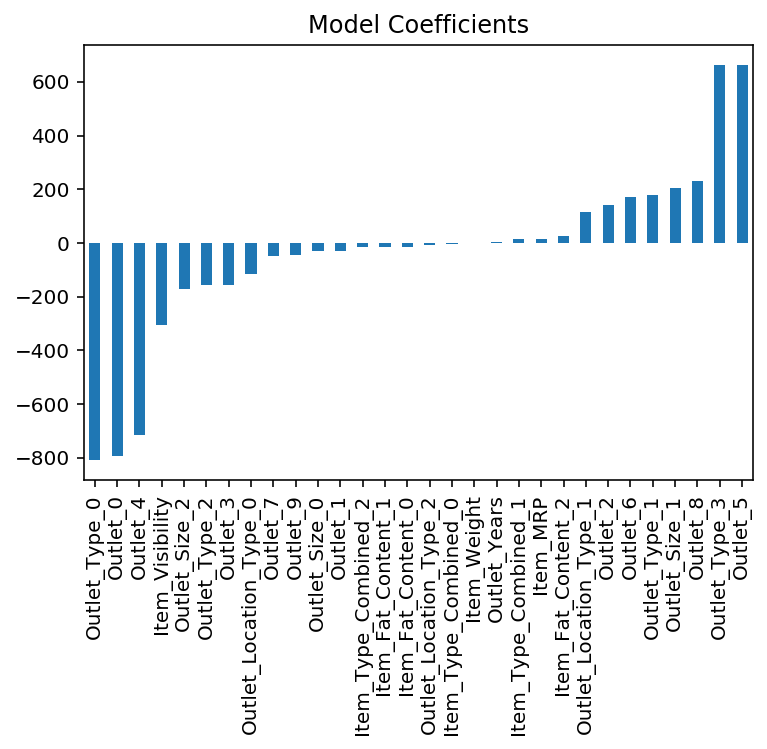

In [52]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
predictors = [x for x in train.columns if x not in [target]+IDcol]
# print predictors
alg1 = LinearRegression(normalize=True)
modelfit(alg1, train, test, predictors, target, IDcol, 'alg1.csv')
coef1 = pd.Series(alg1.coef_, predictors).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')


Model Report
RMSE : 1128
CV Score : Mean - 1130 | Std - 44.75 | Min - 1076 | Max - 1217


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


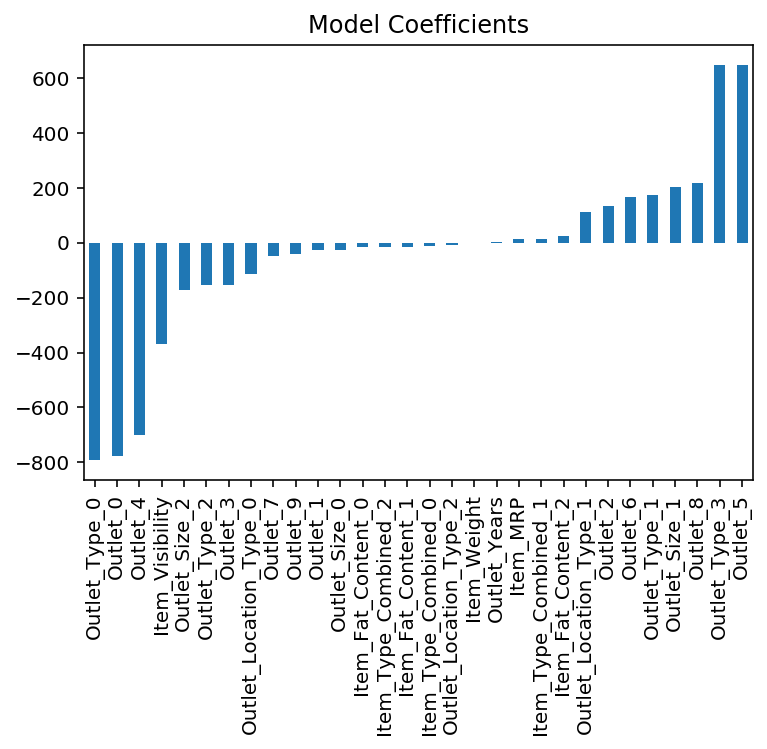

In [53]:
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg2 = Ridge(alpha=0.05,normalize=True)
modelfit(alg2, train, test, predictors, target, IDcol, 'alg2.csv')
coef2 = pd.Series(alg2.coef_, predictors).sort_values()
coef2.plot(kind='bar', title='Model Coefficients')

#### Decision Tree Model


Model Report
RMSE : 1059
CV Score : Mean - 1092 | Std - 45.37 | Min - 1014 | Max - 1183


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


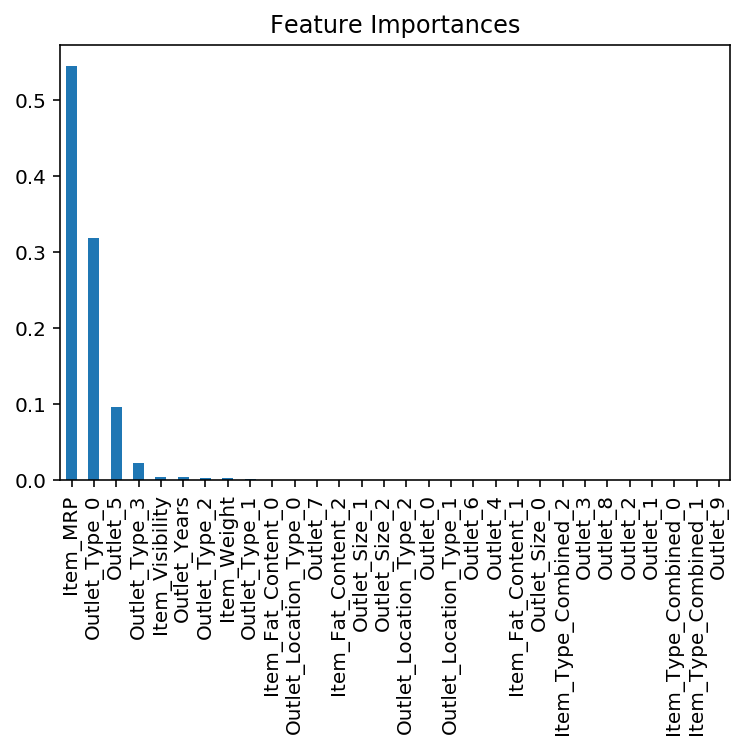

In [54]:
from sklearn.tree import DecisionTreeRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
modelfit(alg3, train, test, predictors, target, IDcol, 'alg3.csv')
coef3 = pd.Series(alg3.feature_importances_, predictors).sort_values(ascending=False)
coef3.plot(kind='bar', title='Feature Importances')


Model Report
RMSE : 1074
CV Score : Mean - 1096 | Std - 43.6 | Min - 1034 | Max - 1174


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


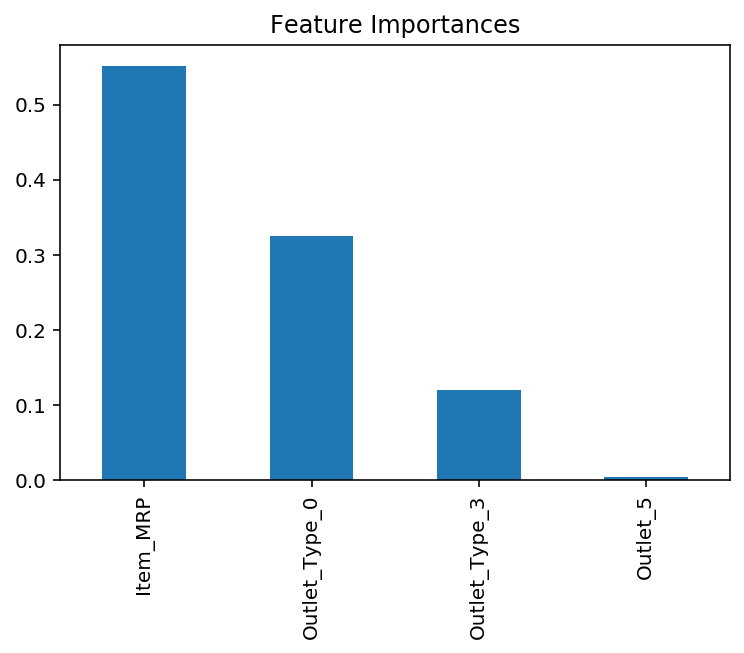

In [56]:
predictors = ['Item_MRP','Outlet_Type_0','Outlet_5','Outlet_Type_3']
alg4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=150)
modelfit(alg4, train, test, predictors, target, IDcol, 'alg4.csv')
coef4 = pd.Series(alg4.feature_importances_, predictors).sort_values(ascending=False)
coef4.plot(kind='bar', title='Feature Importances')

#### Random Forest Model


Model Report
RMSE : 1073
CV Score : Mean - 1083 | Std - 43.57 | Min - 1021 | Max - 1160


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


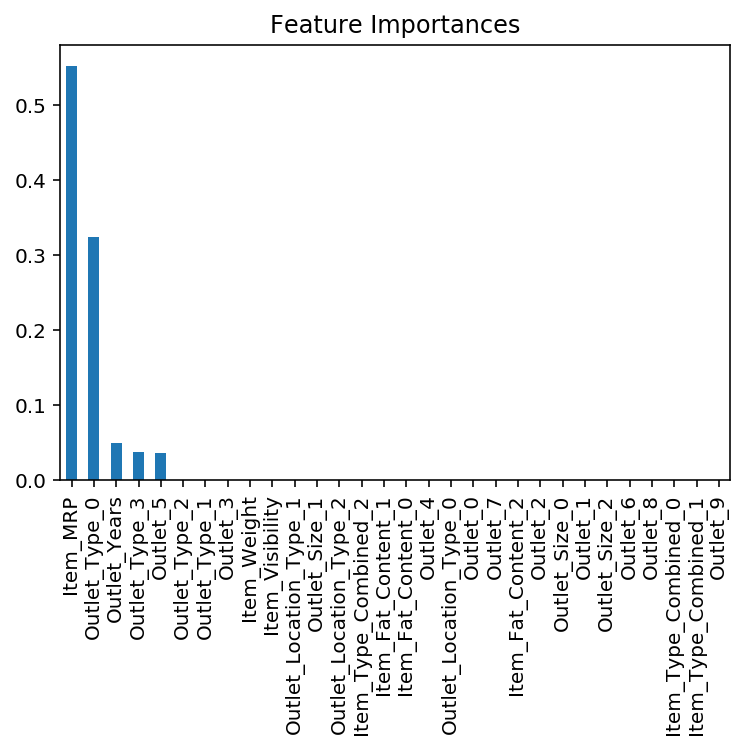

In [58]:
from sklearn.ensemble import RandomForestRegressor
predictors = [x for x in train.columns if x not in [target]+IDcol]
alg5 = RandomForestRegressor(n_estimators=200,max_depth=5, min_samples_leaf=100,n_jobs=4)
modelfit(alg5, train, test, predictors, target, IDcol, 'alg5.csv')
coef5 = pd.Series(alg5.feature_importances_, predictors).sort_values(ascending=False)
coef5.plot(kind='bar', title='Feature Importances')